In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data.csv to data.csv


In [7]:
r = 102317269

def transform_x(x, r):
    a_r = 0.5 * (r % 7)
    b_r = 0.3 * (r % 5 + 1)
    return x + a_r * np.sin(b_r * x)

df = pd.read_csv("data.csv", encoding="latin1")
print(df.columns)

x = df['no2'].dropna().values

z = transform_x(x, r)


Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


/tmp/ipython-input-2850946842.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


Generator Model

In [8]:
def build_generator():
    model = Sequential([
        Dense(16, input_dim=1),
        LeakyReLU(0.2),
        Dense(16),
        LeakyReLU(0.2),
        Dense(1)
    ])
    return model


Discriminator Model

In [9]:
def build_discriminator():
    model = Sequential([
        Dense(32, input_dim=1),
        LeakyReLU(0.2),
        Dense(32),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
    return model


Combining the GAN

In [10]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
    return model


In [11]:
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

epochs = 5000
batch = 64

z_data = z.reshape(-1, 1)

for epoch in range(epochs):
    idx = np.random.randint(0, z_data.shape[0], batch)
    real_samples = z_data[idx]

    noise = np.random.normal(0, 1, (batch, 1))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch, 1)))

    noise = np.random.normal(0, 1, (batch, 1))
    g_loss = gan.train_on_batch(noise, np.ones((batch, 1)))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss_real + d_loss_fake}, G Loss: {g_loss}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.8498210906982422, G Loss: 0.7005059719085693
Epoch 500, D Loss: 1.0218467712402344, G Loss: 0.6859506964683533
Epoch 1000, D Loss: 1.0470739603042603, G Loss: 0.6630069017410278
Epoch 1500, D Loss: 1.1148219108581543, G Loss: 0.612933337688446
Epoch 2000, D Loss: 1.2453995943069458, G Loss: 0.5421450138092041
Epoch 2500, D Loss: 1.4365394115447998, G Loss: 0.46999940276145935
Epoch 3000, D Loss: 1.6682589054107666, G Loss: 0.40742915868759155
Epoch 3500, D Loss: 1.9214138984680176, G Loss: 0.3564978539943695
Epoch 4000, D Loss: 2.1806728839874268, G Loss: 0.315579891204834
Epoch 4500, D Loss: 2.4382576942443848, G Loss: 0.2824656665325165


In [12]:
gen_noise = np.random.normal(0, 1, (5000, 1))
z_fake = generator.predict(gen_noise, verbose=0)


In [18]:
print("\n== TRANSFORMATION PARAMETERS ==")
print("a_r =", a_r)
print("b_r =", b_r)

print("\n== GAN LOSS VALUES ==")
print("Final Generator Loss:", g_loss)
print("Final Discriminator Loss:", d_loss_real + d_loss_fake)

print("\n== SAMPLE GENERATED VALUES (z_f) ==")
print(z_fake[:10].flatten())



== TRANSFORMATION PARAMETERS ==
a_r = 2.5
b_r = 1.5

== GAN LOSS VALUES ==
Final Generator Loss: 0.25537917
Final Discriminator Loss: 2.6921394

== SAMPLE GENERATED VALUES (z_f) ==
[ 99.00567  105.936134 122.360435  99.9764   101.30016  105.63477
 106.20484  100.220024 100.53161  119.96013 ]


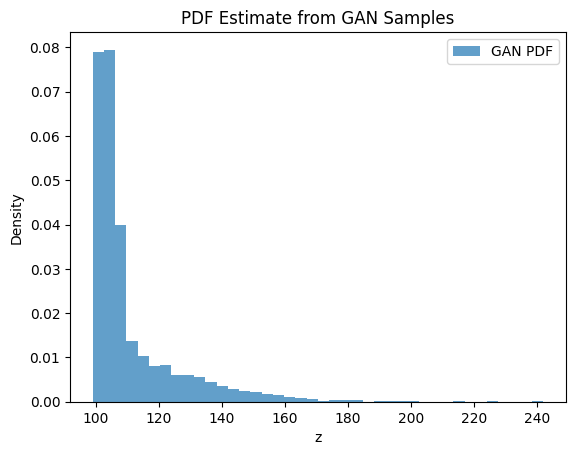

In [13]:
plt.hist(z_fake, bins=40, density=True, alpha=0.7, label='GAN PDF')
plt.title("PDF Estimate from GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()


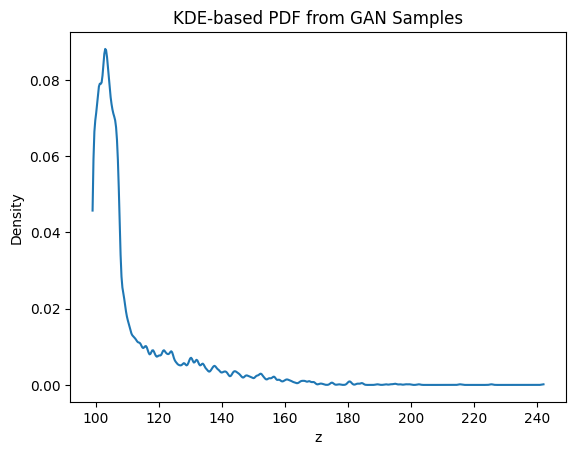

In [14]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(z_fake)
z_grid = np.linspace(min(z_fake), max(z_fake), 500).reshape(-1,1)
log_pdf = kde.score_samples(z_grid)

plt.plot(z_grid, np.exp(log_pdf))
plt.title("KDE-based PDF from GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()
